### Load Packages

In [1]:
import numpy as np
from make_graphs import generate_all_graphs
from graph_loading import load_randomgraph, load_treegraph, load_animal, load_email, load_school, load_usflights, load_clique_plus_animal
from help_functions import saving_results, spectrum_plots
import pandas as pd

### Generating/Loading graphs

In [2]:
generate_all_graphs()

Making Random Graph...
Stats for Random graph:
n: 250.0
<m>: 15656.0
<min deg>: 105.5
<max deg>: 147.66666666666666
<triangles>: 327003.1666666667
<l2>: 102.13223426015655
<lmax>: 151.5919286461665
Total number of timestamps: 6


Making Tree Graph...
Stats for Tree graph:
n: 250.0
<m>: 249.0
<min deg>: 0.16666666666666666
<max deg>: 6.333333333333333
<triangles>: 1.6666666666666667
<l2>: 0.00020536181179220042
<lmax>: 8.04557848957374
Total number of timestamps: 6


Making Animal Graph...
Stats for Animal graph:
n: 202.0
<m>: 1982.6666666666667
<min deg>: 0.0
<max deg>: 67.83333333333333
<triangles>: 20438.0
<l2>: -5.418039443627813e-15
<lmax>: 68.95932897423576
Total number of timestamps: 6


Making Email Graph...


/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/Boston/Project1/SpectralSandwich/make_graphs.py:139: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./Graphs/email/ia-radoslaw-email.edges", header=None,comment='%',


Stats for Email graph:
n: 167.0
<m>: 1133.2
<min deg>: 0.0
<max deg>: 84.0
<triangles>: 3650.5
<l2>: 0.0
<lmax>: 85.37223419727842
Total number of timestamps: 57842


Making School Graph...
Stats for School graph:
n: 242.0
<m>: 2982.0
<min deg>: 0.0
<max deg>: 55.166666666666664
<triangles>: 15403.666666666666
<l2>: 0.0
<lmax>: 57.04349615776218
Total number of timestamps: 3100


Making Airport Graph...


/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/Boston/Project1/SpectralSandwich/make_graphs.py:208: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv('./Graphs/airport/edges.csv')


Stats for Flights graph:
n: 250.0
<m>: 1296.5
<min deg>: 0.0
<max deg>: 66.7
<triangles>: 0.0
<l2>: 0.0
<lmax>: 74.4970918081652
Total number of timestamps: 31




### SDP solution for the DPES problem

In [3]:
import cvxpy as cp
from cvxpy import *
import numpy as np
from help_functions import eigs, Laplacian
import sys
import random
import copy

#Induced Laplacian of Y by Y=xx^T, with x being an indicator vector. 
def induced_laplacian(A, Y):
    E = cp.multiply(Y, A) #induced adjacaceny
    return cp.multiply((cp.sum(E, axis = 1, keepdims=True) @ np.ones((1,len(A)))), np.identity(len(A))) - E 
 

#SDP algorithm for DPES
def SDP_DPES(As, sigma, ret_time = False):
    #Number of nodes
    n = len(As[0])
    #Number of timstamps
    T = len(As)
    
    #Define and solve the CVXPY problem.
    #--------------------------------------------------------------------------------------------------------------
    #Constraints
    #-------------------------------------------------------------------------------------------------------------
    #Y is a Symmetric and PSD  matrix 
    #with Yij = x_i*x_j, where x_i = 1 if node i is part of the solution and x_i = 0 otherwise
    Y = cp.Variable((n+1,n+1), symmetric = True)
    constraints = [Y>>0]

    #Yij is in the range [0, 1] and Y[0,0]=1
    constraints += [Y >= 0]  #we can ommit it
    constraints += [Y <= 1] #we can ommit it
    constraints += [Y[0,0] == 1]
    
    #diag(Y)=x
    constraints += [cp.diag(Y) == Y[0,:]]

    #Spectral constraint: L >> sigma*R, where L, R are the induced laplacians of A_t and A_{t-1} respectively.
    L = 0 
    R = 0
    for t in range(1,T):
            L = induced_laplacian(As[t], Y[1:,1:])
            R = induced_laplacian(As[t-1], Y[1:,1:])
            constraints += [L >> sigma*R]
    #-------------------------------------------------------------------------------------------------------------
    #Objective
    #-------------------------------------------------------
    #Objective function: sum of induced edge-weights.
    density_score = 0
    Aall = np.zeros((n+1,n+1))
    for A in As:
        Aall[1:,1:] += A
    density_score = cp.sum(cp.multiply(Y,Aall))    
    #-------------------------------------------------------
    #Solving the problem
    #-----------------------------------------------------------------
    #Set the problem 
    prob = cp.Problem(cp.Maximize(density_score), constraints)
    #Solve problem
    print('SDP solving...')
    _verbose = True
    if ret_time: _verbose = False
    prob.solve(verbose = _verbose, solver = cp.MOSEK, warm_start=True)
    #------------------------------------------------------------------
    print(f'Compilation time {prob._compilation_time}')
    print(f'Solver Time {prob._solve_time}')
    #--------------------------------------------------------------------------------------------------------------
    if ret_time: return prob._compilation_time, prob._solve_time
    Y = Y.value
    return Y

### Rounding the SDP solution

In [4]:
#Iteratively execute the SDP algorithm until finding a feasible solution
def run_SDP_DPES(As, sigma):
    #Run SDP_DPES and sorted diagonal elements
    Yret = SDP_DPES(As, sigma = sigma)
    Y = np.diag(Yret[1:,1:])
    sorted_ind = np.argsort(-1*Y)
    iterations = [range(len(Y))]
    #Max obective (sum of induced edge-weights) and optimal solution
    max_objective = -1
    best_X = None
    #Iterate over permutations
    for sort_L in [sorted_ind]:
        for iters in iterations:
            flag = True
            X = []
            for i in iters:
                X.append(sort_L[i]) #append the next element
                objective_t = 0     #current density
                eigenvalues_t_minus_1 = [0 for _ in range(len(X))] #eigenvalues
                flag = False
                for A in As:
                    A_t = A[X,:]
                    A_t = A_t[:,X]
                    objective_t += np.sum(A_t)
                    eigenvalues_t = eigs(Laplacian(A_t))
                    eigenvalues_t.sort()
                    flag = False
                    if(np.min(eigenvalues_t-eigenvalues_t_minus_1) < -0.000001):
                        flag = True
                        eigenvalues_t_minus_1 = [0 for _ in range(len(eigenvalues_t))]
                        break
                    else:
                        eigenvalues_t_minus_1 = [eigenvalues_t[j]*sigma for j in range(len(eigenvalues_t))]
                if flag: continue
                elif objective_t >= max_objective:
                    max_objective = objective_t
                    best_X = copy.deepcopy(X)
    if len(best_X)>1: best_X = [x for x in best_X if np.sum([As[i][x,best_X] for i in range(len(As))])>0]
    
    #Induced Adjacencies for all A_t
    for i in range(len(As)):
        As[i] = As[i][best_X,:]
        As[i] = As[i][:,best_X] 
    return Yret, As, best_X

### NDS - Greedy Solution

In [5]:
#Peeling algorithm; iteratively removing the node with the minimum sum of edge-weights and returns nodes
#with the maximum sum of induced edge-weight found.
def peeling(A):
    n = len(A)
    deg_list = [np.sum(A[i,:]) for i in range(n)]
    x_all = [i for i in range(n)]
    x_max = np.argsort(deg_list)[-1:][0]
    x = {x_max, }
    x_all.remove(x_max)
    deg_list[x_max] = 1000000000
    c = 0
    An = copy.deepcopy(A)
    while (np.sum(An))<0 :
        c+=1
        for neigh in range(n):
            if A[x_max,neigh]==0: continue
            if neigh not in x:
                deg_list[neigh] = deg_list[neigh] - A[x_max, neigh]
        x_max = np.argsort(deg_list)[0]
        x.add(x_max)
        deg_list[x_max] = 1000000000
        x_all.remove(x_max)
        An = copy.deepcopy(A)[list(x_all),:]
        An = An[:,list(x_all)]
    return list(x_all)

#Negative Densest Subgraph
def NDS(As, alpha = 1000000):
    print('Running NDS...')
    #number of nodes
    n = len(As[0])
    #init nxn weighted adjacency matrix
    Anew = np.zeros((n, n))
    for t in range(len(As)-1,-1,-1): #from t in {T, T-1,...,1}
        for i in range(n):
            for j in range(n):
                if i == j: continue
                if As[t][i,j] == 0: continue
                if (Anew[i,j] == len(As)-t-1): #if edge is appeared in all timestamts from t to T
                    Anew[i,j] += As[t][i,j]    #increase the edge-weight of the new matrix
                else:                                
                    Anew[i,j] -= alpha #else decrease by alpha
    best_X = peeling(Anew)
    if len(best_X)>1: 
        best_X2 = [x for x in best_X if np.sum([As[i][x,best_X] for i in range(len(As))])>0]
        if len(best_X2)>0: best_X = best_X2
            
    #Induced Adjacencies for all A_t
    for i in range(len(As)):
        As[i] = As[i][best_X,:]
        As[i] = As[i][:,best_X] 
    return As, best_X

## Run Experiments

In [6]:
#Function for executing the experiments
# - fname: folder/file name
# - load_function: function for loading data
# - sigmas: list of sigma parameters used in DPES algorithm
# - n: number of nodes (if graph has more than n nodes then take the induced subgraph spanned by the first n nodes)
# - T: number of timestamps
# - weighted: False(True resp.) for using the Adjacency (weighted Adjacecny resp.)
def run_experiments(fname, load_function, sigmas = [1], n = 100, 
                    T = range(5), weighted = True, write_extra = False):
    SDStxt=""
    Ys = []
    for sigma in sigmas:
        #filanems to save data
        filename = f'{fname}_{sigma}'
        #NDS
        if write_extra == False: 
            As = load_function(n, T, weighted)
            As_NDS, X_NDS = NDS(As)
            saving_results(As_NDS, X_NDS, filename, 'NDS', SDStxt, len(T), weighted)
        #SDP
        As = load_function(n, T, weighted)
        Yret, As_PSD, X_PSD = run_SDP_DPES(As, sigma)
        Ys.append(Yret)
        saving_results(As_PSD, X_PSD, filename, 'SDP', SDStxt, len(T), weighted, write_extra)
        #Saving spectrum plots
        if write_extra == False:  spectrum_plots(As_PSD, As_NDS, f'{filename}{SDStxt}_{len(T)}', showall=False, folder = 'Plots_')
    return Ys

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 06:59:00 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 06:59:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 06:59:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 06:59:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 06:59:00 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 06:59:00 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 06:59:35 PM:   Dual.    obj: -1.2663859654e+03   nrm: 1e+00    Viol.  con: 0e+00    var: 2e-09    barvar: 2e-08  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 05 06:59:35 PM: Problem status: optimal
(CVXPY) Feb 05 06:59:35 PM: Optimal value: 1.266e+03
(CVXPY) Feb 05 06:59:35 PM: Compilation took 1.196e+01 seconds
(CVXPY) Feb 05 06:59:35 PM: Solver (including time spent in interface) took 2.293e+01 seconds
Compilation time 11.962351083755493
Solver Time 22.929337739944458


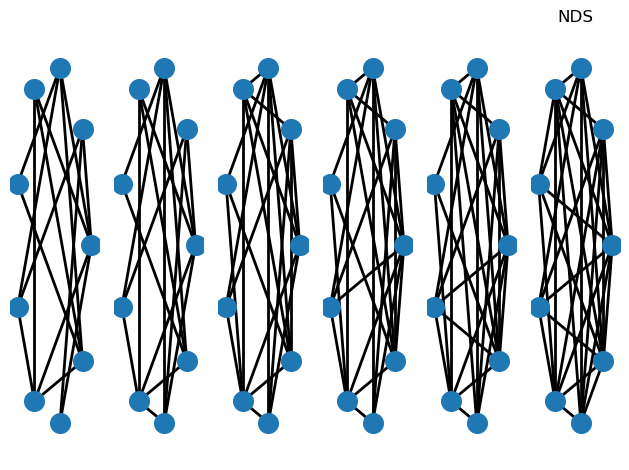

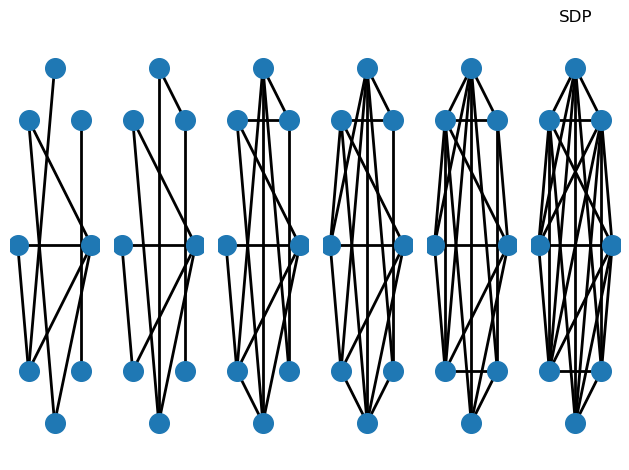

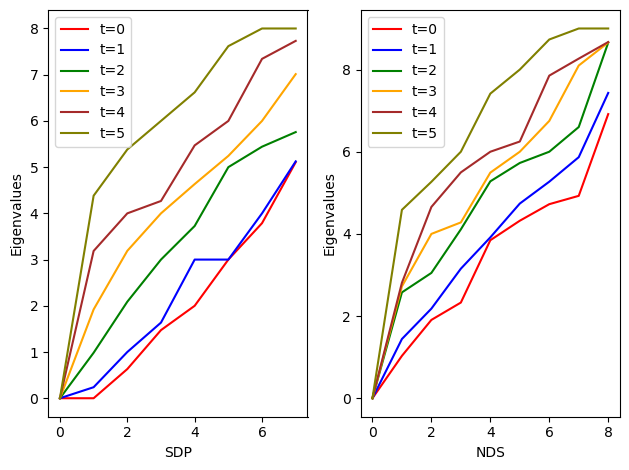

In [7]:
#set n = 
_ = run_experiments(f'randomgraph', load_randomgraph, sigmas = [1], n=100, T = range(6), weighted = False)

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 06:59:39 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 06:59:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 06:59:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 06:59:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 06:59:39 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 06:59:39 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 07:00:08 PM: 22  2.8e-07  3.3e-08  8.8e-13  1.00e+00   -1.657423372e+02  -1.657423372e+02  1.3e-08  19.42 
(CVXPY) Feb 05 07:00:10 PM: 23  1.4e-07  1.3e-07  9.1e-14  1.00e+00   -1.657423382e+02  -1.657423382e+02  2.9e-09  21.53 
(CVXPY) Feb 05 07:00:10 PM: Optimizer terminated. Time: 21.57   
(CVXPY) Feb 05 07:00:10 PM: 
(CVXPY) Feb 05 07:00:10 PM: 
(CVXPY) Feb 05 07:00:10 PM: Interior-point solution summary
(CVXPY) Feb 05 07:00:10 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 05 07:00:10 PM:   Solution status : OPTIMAL
(CVXPY) Feb 05 07:00:10 PM:   Primal.  obj: -1.6574233824e+02   nrm: 1e+02    Viol.  con: 9e-08    var: 8e-10    barvar: 0e+00  
(CVXPY) Feb 05 07:00:10 PM:   Dual.    obj: -1.6574233824e+02   nrm: 2e+00    Viol.  con: 0e+00    var: 2e-09    barvar: 2e-09  
-------------------------------------------------------------------------------
                                    Summary                                    
--------------------------

/Users/au711141/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


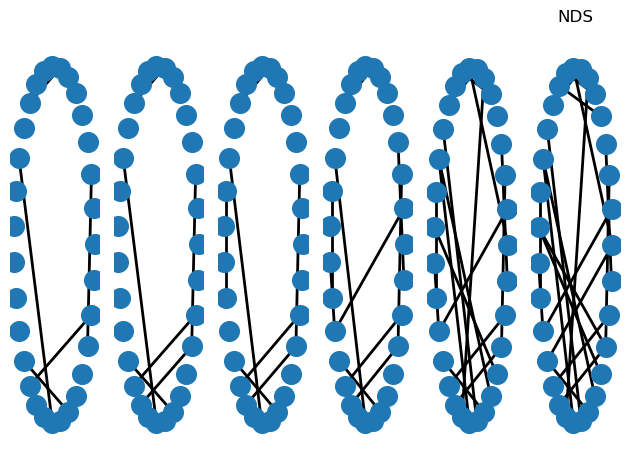

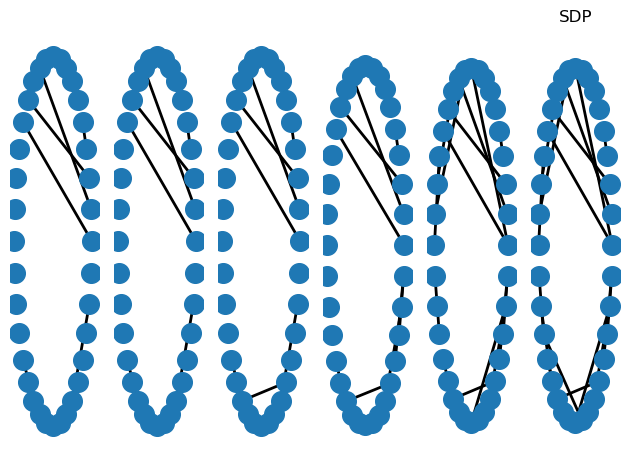

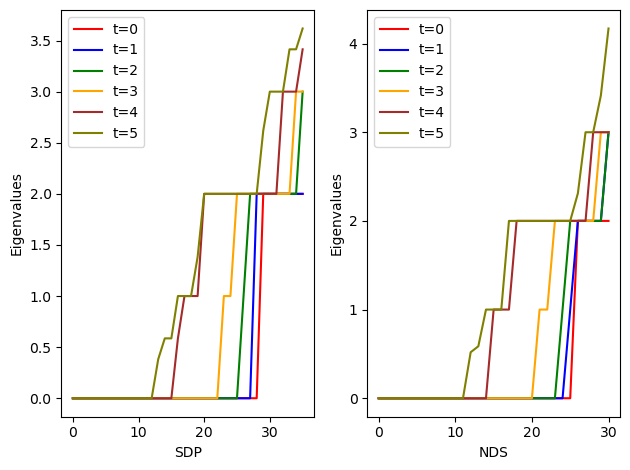

In [8]:
_ = run_experiments(f'treegraph', load_treegraph, sigmas = [1], n=100, T = range(6), weighted = False)

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 07:00:13 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 07:00:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 07:00:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 07:00:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:00:13 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 07:00:13 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 07:00:47 PM: 22  3.4e-07  2.8e-08  1.7e-11  9.54e-01   -4.055986196e+02  -4.055986199e+02  2.8e-08  19.76 
(CVXPY) Feb 05 07:00:48 PM: 23  2.1e-07  1.8e-08  8.9e-12  9.59e-01   -4.055974640e+02  -4.055974641e+02  1.8e-08  20.86 
(CVXPY) Feb 05 07:00:49 PM: 24  1.3e-07  1.1e-08  4.1e-12  9.62e-01   -4.055966134e+02  -4.055966135e+02  1.0e-08  21.81 
(CVXPY) Feb 05 07:00:50 PM: 25  5.9e-08  4.9e-09  1.3e-12  9.73e-01   -4.055959386e+02  -4.055959387e+02  4.8e-09  22.62 
(CVXPY) Feb 05 07:00:51 PM: 26  3.3e-08  3.0e-09  5.6e-13  9.77e-01   -4.055956729e+02  -4.055956729e+02  2.7e-09  23.50 
(CVXPY) Feb 05 07:00:51 PM: Optimizer terminated. Time: 23.52   
(CVXPY) Feb 05 07:00:51 PM: 
(CVXPY) Feb 05 07:00:51 PM: 
(CVXPY) Feb 05 07:00:51 PM: Interior-point solution summary
(CVXPY) Feb 05 07:00:51 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 05 07:00:51 PM:   Solution status : OPTIMAL
(CVXPY) Feb 05 07:00:51 PM:   Primal.  obj: -4.0559567288e+02   nrm: 4e+02    

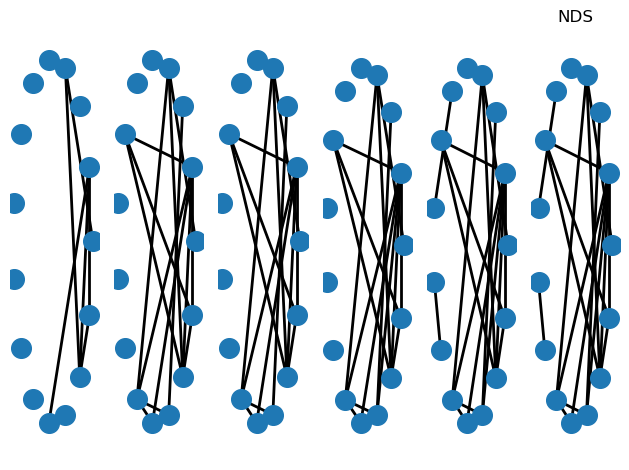

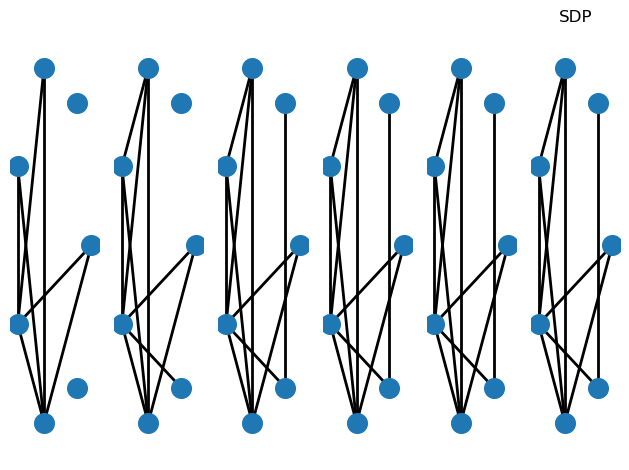

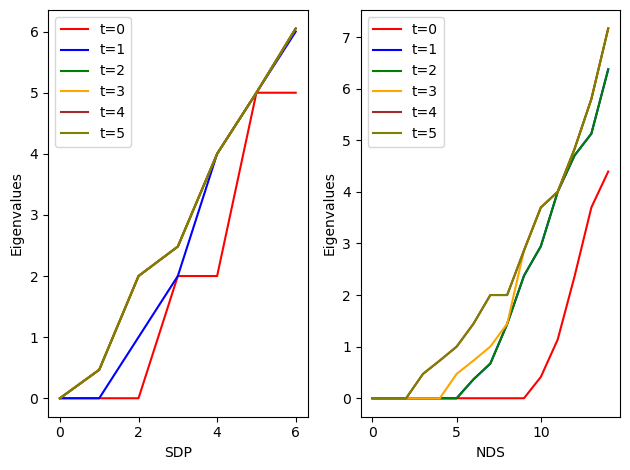

In [9]:
_ = run_experiments(f'email', load_email, sigmas = [1], n=100, T = range(6), weighted = False)

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 07:00:56 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 07:00:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 07:00:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 07:00:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:00:56 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 07:00:56 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 07:01:30 PM: 22  7.1e-05  5.9e-06  9.5e-08  8.25e-01   -2.112531594e+03  -2.112531808e+03  5.9e-06  19.23 
(CVXPY) Feb 05 07:01:31 PM: 23  3.7e-05  3.1e-06  3.8e-08  8.31e-01   -2.111705688e+03  -2.111705813e+03  3.1e-06  19.97 
(CVXPY) Feb 05 07:01:32 PM: 24  2.1e-05  1.8e-06  1.7e-08  8.70e-01   -2.111268393e+03  -2.111268472e+03  1.8e-06  20.76 
(CVXPY) Feb 05 07:01:33 PM: 25  8.5e-06  7.0e-07  4.6e-09  8.95e-01   -2.110872093e+03  -2.110872130e+03  7.0e-07  21.56 
(CVXPY) Feb 05 07:01:33 PM: 26  5.3e-06  4.4e-07  2.3e-09  9.03e-01   -2.110757891e+03  -2.110757916e+03  4.4e-07  22.37 
(CVXPY) Feb 05 07:01:34 PM: 27  1.5e-06  1.2e-07  3.6e-10  9.17e-01   -2.110605511e+03  -2.110605519e+03  1.2e-07  23.14 
(CVXPY) Feb 05 07:01:35 PM: 28  6.9e-07  5.7e-08  1.2e-10  9.40e-01   -2.110570625e+03  -2.110570628e+03  5.7e-08  24.06 
(CVXPY) Feb 05 07:01:36 PM: 29  3.7e-07  3.1e-08  4.8e-11  9.58e-01   -2.110556057e+03  -2.110556059e+03  3.1e-08  24.87 
(CVXPY) Feb 05 07:01:37 

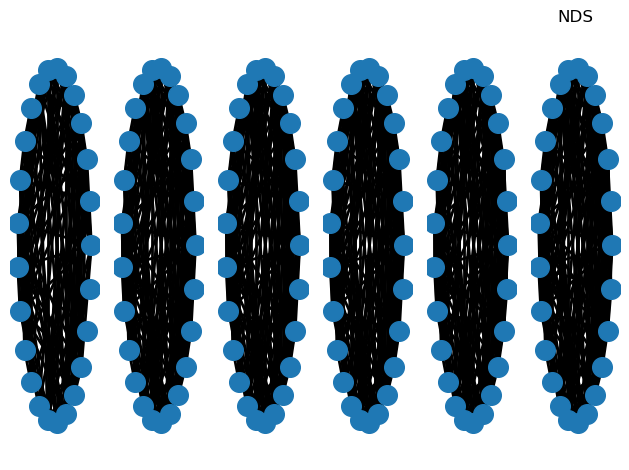

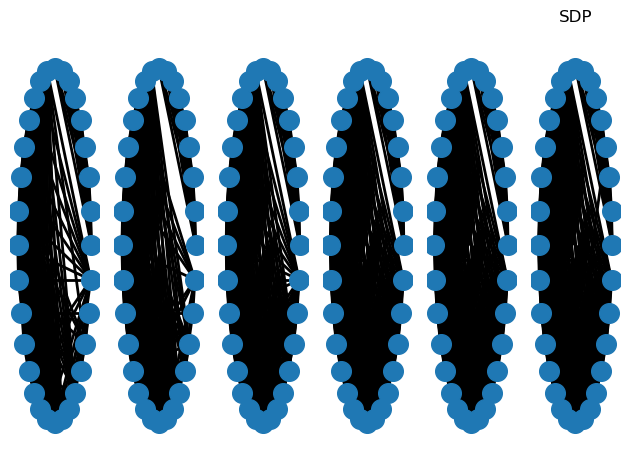

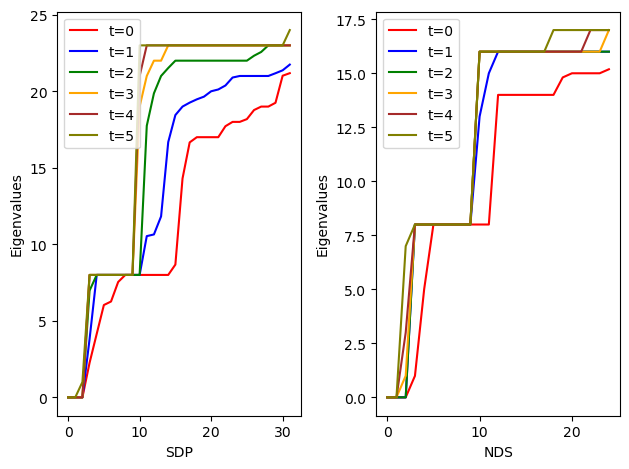

In [10]:
_ = run_experiments(f'animal', load_animal, sigmas = [1], n=100, T = range(6), weighted = False)

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 07:01:48 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 07:01:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 07:01:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 07:01:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:01:48 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 07:01:48 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 07:02:19 PM: 22  1.9e-05  1.5e-06  3.1e-09  9.46e-01   -2.140210508e+02  -2.140210523e+02  1.5e-06  17.89 
(CVXPY) Feb 05 07:02:20 PM: 23  5.4e-06  4.5e-07  5.1e-10  9.39e-01   -2.140109352e+02  -2.140109357e+02  4.5e-07  18.75 
(CVXPY) Feb 05 07:02:21 PM: 24  2.8e-06  2.3e-07  1.9e-10  9.17e-01   -2.140085356e+02  -2.140085358e+02  2.3e-07  19.63 
(CVXPY) Feb 05 07:02:21 PM: 25  2.4e-06  1.7e-07  1.3e-10  8.91e-01   -2.140079300e+02  -2.140079302e+02  1.7e-07  20.45 
(CVXPY) Feb 05 07:02:22 PM: 26  9.4e-07  6.8e-08  3.3e-11  9.18e-01   -2.140065874e+02  -2.140065875e+02  6.8e-08  21.27 
(CVXPY) Feb 05 07:02:23 PM: 27  6.1e-07  4.4e-08  1.7e-11  9.48e-01   -2.140062603e+02  -2.140062603e+02  4.4e-08  22.11 
(CVXPY) Feb 05 07:02:24 PM: 28  3.7e-07  2.7e-08  8.3e-12  9.34e-01   -2.140060072e+02  -2.140060073e+02  2.7e-08  22.93 
(CVXPY) Feb 05 07:02:25 PM: 29  2.2e-07  1.6e-08  3.9e-12  9.20e-01   -2.140058376e+02  -2.140058376e+02  1.6e-08  23.73 
(CVXPY) Feb 05 07:02:26 

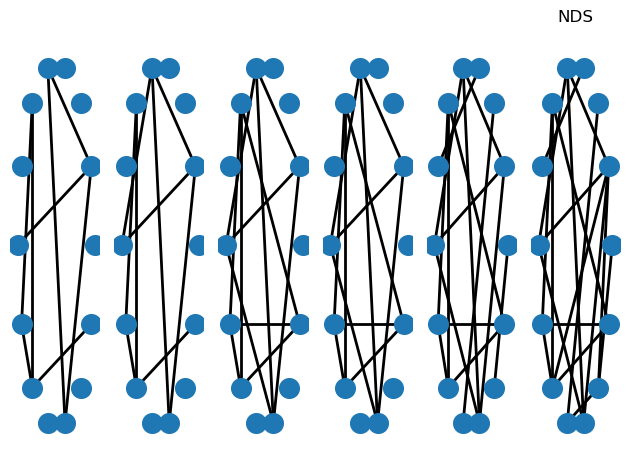

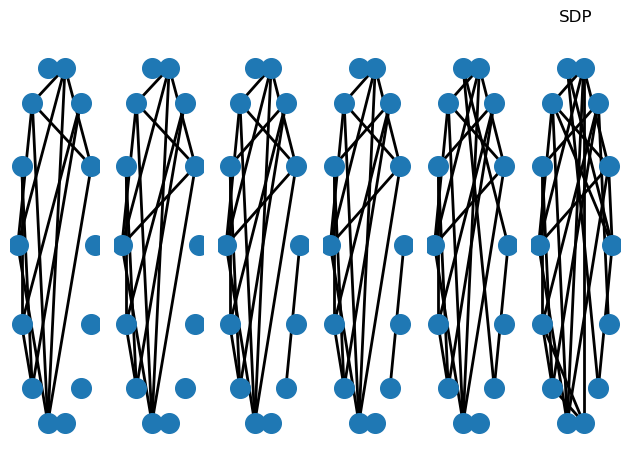

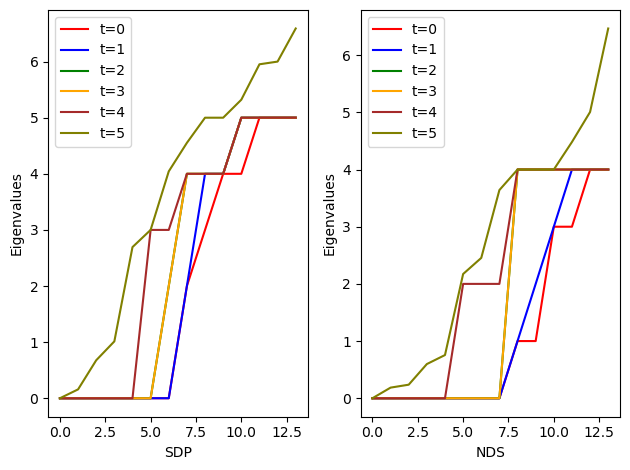

In [11]:
_ = run_experiments(f'school', load_school, sigmas = [1], n=100, T = range(6), weighted = False)

Running NDS...
SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 07:02:39 PM: Your problem has 10201 variables, 10 constraints, and 0 parameters.
(CVXPY) Feb 05 07:02:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 07:02:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 07:02:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:02:39 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 07:02:39 PM: Reduction chain: FlipObjective ->

(CVXPY) Feb 05 07:03:16 PM: 22  6.5e-02  5.4e-02  2.4e-05  8.64e-01   -9.701879259e+03  -9.701928550e+03  1.1e-04  18.08 
(CVXPY) Feb 05 07:03:16 PM: 23  3.9e-02  3.3e-02  1.2e-05  8.96e-01   -9.539636252e+03  -9.539668552e+03  6.4e-05  18.83 
(CVXPY) Feb 05 07:03:17 PM: 24  1.1e-02  9.5e-03  2.0e-06  9.20e-01   -9.345555856e+03  -9.345566728e+03  1.9e-05  19.59 
(CVXPY) Feb 05 07:03:18 PM: 25  4.5e-03  3.8e-03  5.1e-07  9.48e-01   -9.289671086e+03  -9.289675675e+03  7.3e-06  20.43 
(CVXPY) Feb 05 07:03:19 PM: 26  2.1e-03  1.7e-03  1.6e-07  9.58e-01   -9.268770572e+03  -9.268772818e+03  3.4e-06  21.30 
(CVXPY) Feb 05 07:03:20 PM: 27  1.0e-03  8.5e-04  5.7e-08  9.72e-01   -9.259105241e+03  -9.259106376e+03  1.7e-06  22.11 
(CVXPY) Feb 05 07:03:21 PM: 28  2.7e-04  2.3e-04  8.1e-09  9.76e-01   -9.252057885e+03  -9.252058207e+03  4.4e-07  23.07 
(CVXPY) Feb 05 07:03:22 PM: 29  3.9e-05  3.2e-05  4.4e-10  9.85e-01   -9.249695414e+03  -9.249695462e+03  6.3e-08  24.00 
(CVXPY) Feb 05 07:03:23 

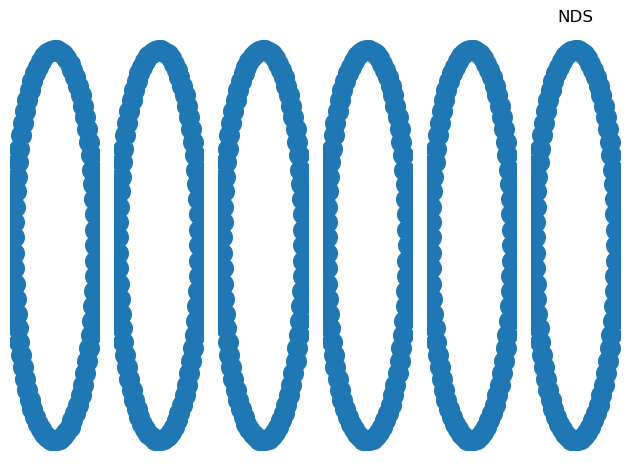

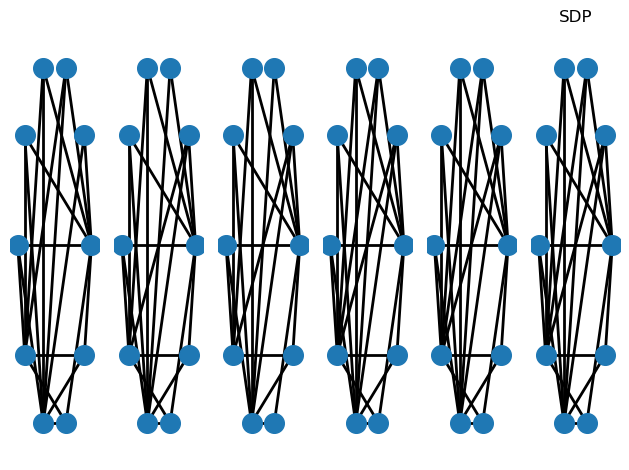

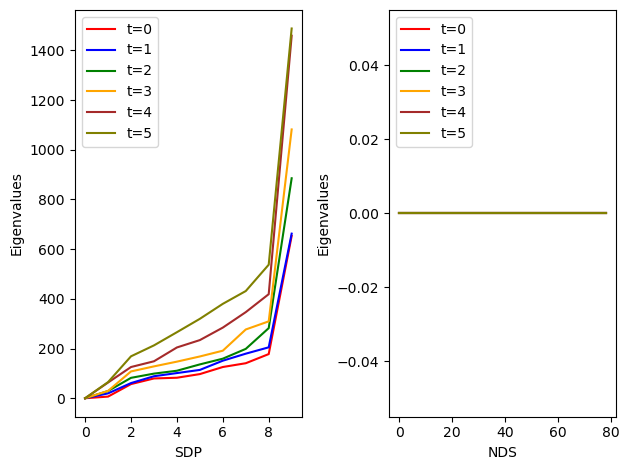

In [12]:
_ = run_experiments(f'usflights', load_usflights, sigmas = [1], n=100, T = range(6), weighted = True) #use edge-weights

### Tuning $\sigma$ parameter

SDP solving...
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 05 07:03:32 PM: Your problem has 10201 variables, 11 constraints, and 0 parameters.
(CVXPY) Feb 05 07:03:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 07:03:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 07:03:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:03:32 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 07:03:32 PM: Reduction chain: FlipObjective -> Dcp2Cone -> Cv

(CVXPY) Feb 05 07:04:27 PM: 22  1.3e-03  5.3e-05  3.2e-06  8.94e-01   -1.220490666e+04  -1.220490969e+04  5.3e-05  26.98 
(CVXPY) Feb 05 07:04:28 PM: 23  7.9e-04  3.2e-05  1.5e-06  9.02e-01   -1.220103119e+04  -1.220103314e+04  3.2e-05  28.11 
(CVXPY) Feb 05 07:04:29 PM: 24  3.7e-04  1.5e-05  5.2e-07  8.65e-01   -1.219741418e+04  -1.219741525e+04  1.5e-05  28.99 
(CVXPY) Feb 05 07:04:30 PM: 25  2.5e-04  1.0e-05  3.0e-07  8.54e-01   -1.219611945e+04  -1.219612023e+04  1.0e-05  29.90 
(CVXPY) Feb 05 07:04:31 PM: 26  1.1e-04  4.5e-06  9.4e-08  8.43e-01   -1.219430803e+04  -1.219430844e+04  4.5e-06  30.82 
(CVXPY) Feb 05 07:04:32 PM: 27  4.7e-05  1.9e-06  2.8e-08  8.73e-01   -1.219326264e+04  -1.219326283e+04  1.9e-06  31.77 
(CVXPY) Feb 05 07:04:33 PM: 28  7.2e-06  2.9e-07  1.8e-09  9.16e-01   -1.219246253e+04  -1.219246257e+04  2.9e-07  32.81 
(CVXPY) Feb 05 07:04:35 PM: 29  4.6e-07  1.7e-08  2.4e-11  9.89e-01   -1.219231232e+04  -1.219231233e+04  1.6e-08  34.30 
(CVXPY) Feb 05 07:04:36 

(CVXPY) Feb 05 07:05:17 PM: 2   2.1e+01  9.4e-01  9.7e-01  2.28e-01   -4.316447298e+02  -4.317050728e+02  9.4e-01  3.33  
(CVXPY) Feb 05 07:05:18 PM: 3   1.6e+01  7.1e-01  8.0e-01  2.14e-01   -1.987713132e+03  -1.988008240e+03  7.1e-01  4.46  
(CVXPY) Feb 05 07:05:19 PM: 4   1.1e+01  4.8e-01  6.0e-01  -1.06e-02  -4.274185623e+03  -4.274801465e+03  4.8e-01  5.68  
(CVXPY) Feb 05 07:05:21 PM: 5   5.2e+00  2.3e-01  2.9e-01  -1.37e-01  -8.977815061e+03  -8.978756019e+03  2.3e-01  6.78  
(CVXPY) Feb 05 07:05:22 PM: 6   3.4e+00  1.5e-01  1.6e-01  3.01e-01   -9.432976534e+03  -9.433627194e+03  1.5e-01  7.90  
(CVXPY) Feb 05 07:05:23 PM: 7   2.6e+00  1.2e-01  1.2e-01  5.02e-01   -9.420177735e+03  -9.420732595e+03  1.2e-01  8.97  
(CVXPY) Feb 05 07:05:24 PM: 8   1.5e+00  6.8e-02  5.6e-02  5.48e-01   -9.235782123e+03  -9.236199982e+03  6.8e-02  10.16 
(CVXPY) Feb 05 07:05:25 PM: 9   6.1e-01  2.7e-02  1.6e-02  5.53e-01   -8.657908861e+03  -8.658152316e+03  2.7e-02  11.47 
(CVXPY) Feb 05 07:05:26 

(CVXPY) Feb 05 07:06:28 PM: 
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - threads                : 8               
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - solved problem         : the primal      
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - Constraints            : 5151
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - Cones                  : 1
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - Scalar variables       : 10404             conic                  : 102             
(CVXPY) Feb 05 07:06:28 PM: Optimizer  - Semi-definite variables: 7                 scalarized             : 35451           
(CVXPY) Feb 05 07:06:28 PM: Factor     - setup time             : 1.09              dense det. time        : 0.59            
(CVXPY) Feb 05 07:06:28 PM: Factor     - ML order time          : 0.18              GP order time          : 0.01            
(CVXPY) Feb 05 07:06:28 PM: Factor     - nonzeros before factor : 1.33e+07          after factor           : 1.33e+07        
(CVXPY) Feb 05 07:06:28 PM: Factor  

(CVXPY) Feb 05 07:07:24 PM:   Scalar variables       : 20504           
(CVXPY) Feb 05 07:07:24 PM:   Matrix variables       : 7               
(CVXPY) Feb 05 07:07:24 PM:   Integer variables      : 0               
(CVXPY) Feb 05 07:07:24 PM: 
(CVXPY) Feb 05 07:07:24 PM: Optimizer started.
(CVXPY) Feb 05 07:07:24 PM: Presolve started.
(CVXPY) Feb 05 07:07:24 PM: Linear dependency checker started.
(CVXPY) Feb 05 07:07:24 PM: Linear dependency checker terminated.
(CVXPY) Feb 05 07:07:24 PM: Eliminator started.
(CVXPY) Feb 05 07:07:24 PM: Freed constraints in eliminator : 0
(CVXPY) Feb 05 07:07:24 PM: Eliminator terminated.
(CVXPY) Feb 05 07:07:24 PM: Eliminator - tries                  : 1                 time                   : 0.00            
(CVXPY) Feb 05 07:07:24 PM: Lin. dep.  - tries                  : 1                 time                   : 0.01            
(CVXPY) Feb 05 07:07:24 PM: Lin. dep.  - number                 : 0               
(CVXPY) Feb 05 07:07:24 PM: Presolv

(CVXPY) Feb 05 07:07:53 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Feb 05 07:07:53 PM: Applying reduction FlipObjective
(CVXPY) Feb 05 07:07:53 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 05 07:07:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 05 07:07:53 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 05 07:07:53 PM: Applying reduction MOSEK
(CVXPY) Feb 05 07:08:12 PM: Finished problem compilation (took 1.923e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 05 07:08:12 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Feb 05 07:08:21 PM: Problem
(CVXPY) Feb 05 07:08:21 PM:   Name                   :                 
(CVXPY) Feb 05 07:08:21 PM:   Objective sense        : maximize        
(CVX

(CVXPY) Feb 05 07:08:53 PM: 31  3.3e-07  5.8e-09  5.3e-12  9.94e-01   -1.657230362e+03  -1.657230362e+03  5.8e-09  31.71 
(CVXPY) Feb 05 07:08:54 PM: 32  1.4e-07  3.2e-09  1.5e-12  9.96e-01   -1.657227766e+03  -1.657227767e+03  2.4e-09  32.85 
(CVXPY) Feb 05 07:08:55 PM: 33  6.8e-08  2.0e-09  4.8e-13  9.95e-01   -1.657226755e+03  -1.657226755e+03  1.2e-09  33.89 
(CVXPY) Feb 05 07:08:56 PM: 34  3.1e-08  2.6e-09  1.7e-13  9.91e-01   -1.657226295e+03  -1.657226295e+03  5.8e-10  34.91 
(CVXPY) Feb 05 07:08:57 PM: 35  3.1e-08  2.6e-09  1.7e-13  9.93e-01   -1.657226295e+03  -1.657226295e+03  5.8e-10  35.93 
(CVXPY) Feb 05 07:08:58 PM: 36  3.1e-08  2.6e-09  1.7e-13  9.91e-01   -1.657226295e+03  -1.657226295e+03  5.8e-10  37.11 
(CVXPY) Feb 05 07:08:59 PM: 37  1.9e-08  1.7e-09  6.3e-14  9.92e-01   -1.657226069e+03  -1.657226069e+03  3.0e-10  38.21 
(CVXPY) Feb 05 07:09:01 PM: 38  1.9e-08  1.7e-09  6.2e-14  1.00e+00   -1.657226069e+03  -1.657226069e+03  3.0e-10  39.43 
(CVXPY) Feb 05 07:09:02 

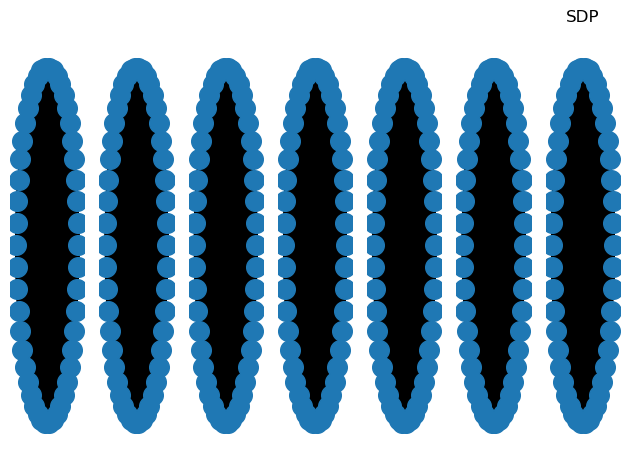

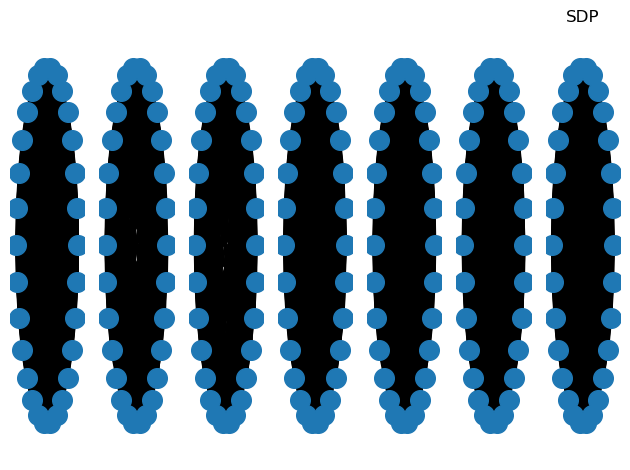

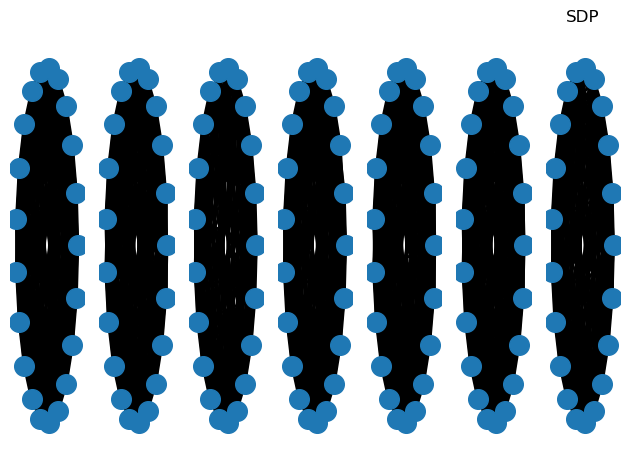

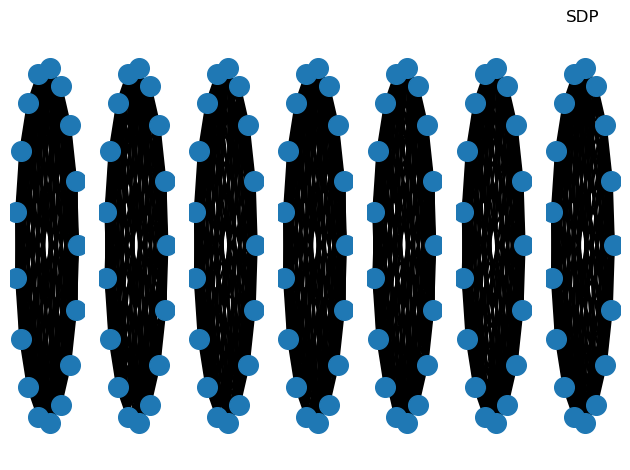

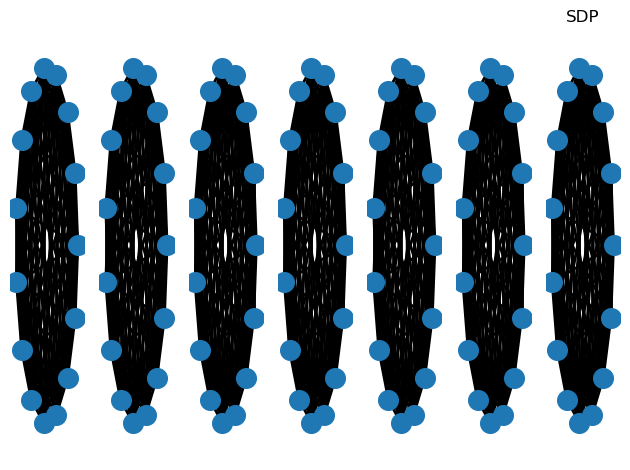

In [13]:
sigmas = [0.1, 0.3, 0.5, 0.7, 0.9]
_ = run_experiments(f'animal_sigma', load_clique_plus_animal, sigmas, n=100, 
                T = range(6), weighted = False, write_extra = True)
data = {}
for sigma in sigmas:
    data[sigma] = pd.read_csv(f'./Results_/animal_sigma_{sigma}_data_PSD_6.txt', sep = ' ')

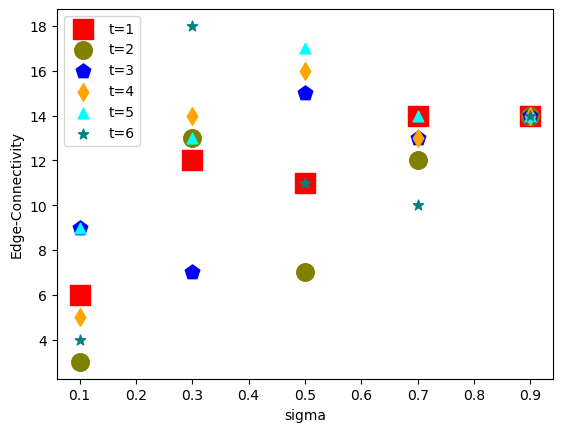

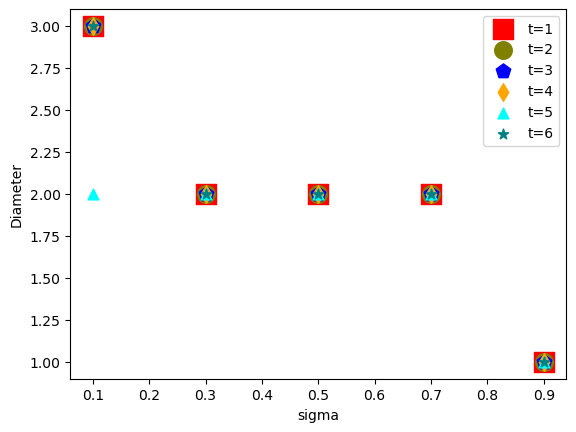

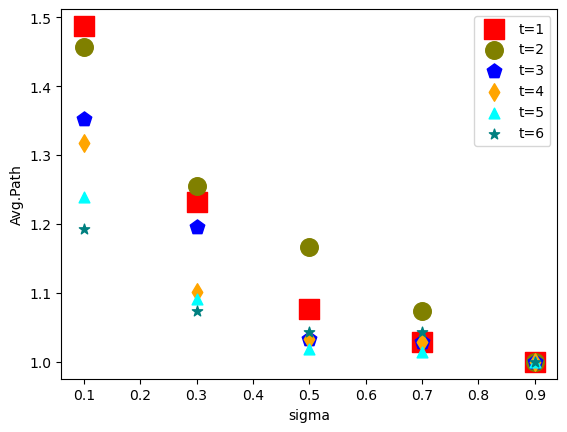

In [14]:
import matplotlib.pyplot as plt
colors = ['red', 'olive', 'blue', 'orange', 'cyan', 'teal']
markers = ["s" , "o" , "p" , "d", "^", "*"]
sizes = 20*np.array([10, 8, 6, 4, 3, 3])
labels = ['t=1','t=2','t=3','t=4','t=5','t=6']
names = {'Edge-Connectivity': 'edgecon', 'Diameter':'diam', 'Avg.Path':'avgpath'}
for name in names:
    ax = plt.subplot(111)
    for i in range(len(sigmas)):
        for j in range(len(data[sigmas[i]][names[name]].values[1:])):
            if((i==0)): ax.scatter(sigmas[i],data[sigmas[i]][names[name]].values[1:][j], c=colors[j], marker = markers[j], 
                                               s = sizes[j], label=labels[j])
            else: ax.scatter(sigmas[i],data[sigmas[i]][names[name]].values[1:][j], c=colors[j], marker = markers[j], 
                                               s = sizes[j])
    
    plt.ylabel(f'{name}')
    plt.xlabel("sigma")
    plt.legend()
    plt.show()
